# Water Potability

### 1. Import libraries needed

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import keras

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

### 2. Load data

In [2]:
df = pd.read_csv("water_potability.csv", header=0)
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


### 3. Preprocess Data

In [3]:
df = df.dropna(how="any")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1
3269,11.491011,94.812545,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264,1
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


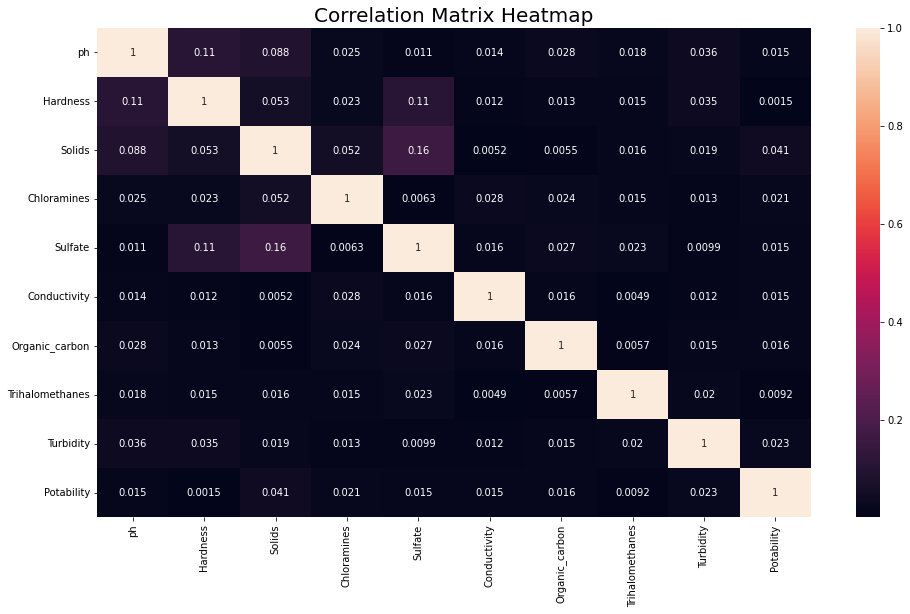

In [5]:
# See correlation
plt.figure(figsize=(16, 9))
sns.heatmap(abs(df.corr()), cbar=True, annot=True)
plt.title("Correlation Matrix Heatmap", fontdict={"size": 20})
plt.xticks()
plt.yticks()
plt.show()

In [6]:
corr_df = abs(df.corr())
corr_df
strong_relation_features = pd.Series(corr_df["Potability"]).nlargest(n=8).iloc[1:]
strong_relation_features

Solids            0.040674
Turbidity         0.022682
Chloramines       0.020784
Organic_carbon    0.015567
Conductivity      0.015496
Sulfate           0.015303
ph                0.014530
Name: Potability, dtype: float64

### 4. Drop Outliers

In [7]:
def check_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Menghitung RUB dan RLB.
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = (df < lower_limit) | (df > upper_limit)
    return outliers

In [8]:
data_clean = df[
    [
        "Solids",
        "Turbidity",
        "Chloramines",
        "Organic_carbon",
        "Sulfate",
        "ph",
        "Potability",
    ]
]

outliers = dict(check_outlier(data_clean).sum())

for col in outliers:
    print(f"Number of outliers in attribute {col}: {outliers[col]}")
    print(f"Percentage of number of outliers: {100*outliers[col]/len(data_clean):.2f}%")
    print()

Number of outliers in attribute Solids: 28
Percentage of number of outliers: 1.39%

Number of outliers in attribute Turbidity: 11
Percentage of number of outliers: 0.55%

Number of outliers in attribute Chloramines: 43
Percentage of number of outliers: 2.14%

Number of outliers in attribute Organic_carbon: 14
Percentage of number of outliers: 0.70%

Number of outliers in attribute Sulfate: 37
Percentage of number of outliers: 1.84%

Number of outliers in attribute ph: 31
Percentage of number of outliers: 1.54%

Number of outliers in attribute Potability: 0
Percentage of number of outliers: 0.00%



In [9]:
outliers_checked = check_outlier(data_clean)

outliers_indices = outliers_checked.any(axis=1)
data_clean = data_clean[~outliers_indices]

data_clean

,Solids,Turbidity,Chloramines,Organic_carbon,Sulfate,ph,Potability
3,22018.417441,4.628771,8.059332,18.436524,356.886136,8.316766,0
4,17978.986339,4.075075,6.546600,11.558279,310.135738,9.092223,0
5,28748.687739,2.559708,7.544869,8.399735,326.678363,5.584087,0
6,28749.716544,2.672989,7.513408,13.789695,393.663396,10.223862,0
7,13672.091764,4.401425,4.563009,12.363817,303.309771,8.635849,0
...,...,...,...,...,...,...,...
3264,20526.666156,4.390702,6.349561,18.963707,341.256362,5.893103,1
3265,27701.794055,3.361833,6.472914,14.250875,328.886838,8.197353,1
3267,15921.412018,4.613843,6.297312,9.899115,312.931022,8.989900,1
3268,17246.920347,3.442983,7.708117,16.217303,304.510230,6.702547,1


### 4. Split inputs and labels

In [10]:
X = data_clean[
    ["Solids", "Turbidity", "Chloramines", "Organic_carbon", "Sulfate", "ph"]
]
y = data_clean["Potability"]
X

,Solids,Turbidity,Chloramines,Organic_carbon,Sulfate,ph
3,22018.417441,4.628771,8.059332,18.436524,356.886136,8.316766
4,17978.986339,4.075075,6.546600,11.558279,310.135738,9.092223
5,28748.687739,2.559708,7.544869,8.399735,326.678363,5.584087
6,28749.716544,2.672989,7.513408,13.789695,393.663396,10.223862
7,13672.091764,4.401425,4.563009,12.363817,303.309771,8.635849
...,...,...,...,...,...,...
3264,20526.666156,4.390702,6.349561,18.963707,341.256362,5.893103
3265,27701.794055,3.361833,6.472914,14.250875,328.886838,8.197353
3267,15921.412018,4.613843,6.297312,9.899115,312.931022,8.989900
3268,17246.920347,3.442983,7.708117,16.217303,304.510230,6.702547


### 5. Split data to training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

### 6. Arsitektur model

In [14]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=32, input_shape=(6,), activation="relu"),
        tf.keras.layers.Dense(units=256, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


batch_size = 32

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    steps_per_epoch=len(X_train) / batch_size,
    epochs=200,
    validation_data=(X_test, y_test),
)


loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test loss: {loss}")

print(f"Test accuracy: {accuracy*100}%")

Epoch 1/200
46/46 [==============================] - 1s 6ms/step - loss: 20.9988 - accuracy: 0.5289 - val_loss: 15.1454 - val_accuracy: 0.6005
Epoch 2/200
46/46 [==============================] - 0s 3ms/step - loss: 5.8668 - accuracy: 0.5235 - val_loss: 3.6349 - val_accuracy: 0.6005
Epoch 3/200
46/46 [==============================] - 0s 4ms/step - loss: 8.1020 - accuracy: 0.5255 - val_loss: 2.4744 - val_accuracy: 0.6005
Epoch 4/200
46/46 [==============================] - 0s 3ms/step - loss: 2.7739 - accuracy: 0.5282 - val_loss: 1.8196 - val_accuracy: 0.6005
Epoch 5/200
46/46 [==============================] - 0s 2ms/step - loss: 4.0076 - accuracy: 0.5363 - val_loss: 4.6583 - val_accuracy: 0.6005
Epoch 6/200
46/46 [==============================] - 0s 2ms/step - loss: 4.2137 - accuracy: 0.5181 - val_loss: 1.8763 - val_accuracy: 0.4021
Epoch 7/200
46/46 [==============================] - 0s 2ms/step - loss: 2.5351 - accuracy: 0.5108 - val_loss: 7.7004 - val_accuracy: 0.3995
Epoch 8/200

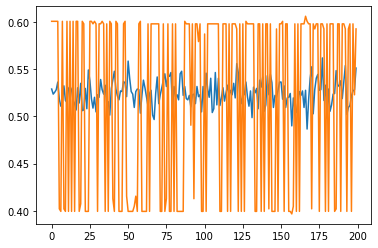

In [15]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()